# Final Project Forecasting

Course: Predictive Modelling Analytics

Group Member:
- xxx
- xxx
- xxx


## Setup
### Initialize Global Variables

In [925]:
WINDOW_SIZE = 12 # 12 months (1 year)
FORECAST_WINDOW = 12 # 1 years
ARRIVAL = 'Kedatangan_Internasional'

### Import Libraries, Dependencides and Dataset

In [926]:
# Importing the libraries
# %pip install pmdarima tensorflow

import pandas as pd
from pandas import read_csv
from pandas import to_datetime
from pandas.plotting import autocorrelation_plot

import seaborn as sn

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator


import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# import warnings
# warnings.filterwarnings('ignore')

# Importing the dataset
data = read_csv("Dataset/Data_FP_PAP-C.csv")
data.head()

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,9394,1,01/01/2017
1,2017,2,8775,2,02/01/2017
2,2017,3,11305,3,03/01/2017
3,2017,4,13204,4,04/01/2017
4,2017,5,11792,5,05/01/2017


## Preprocessing

In [927]:
#Checking for missing values
data.isnull().sum()

Tahun                       0
Bulan                       0
Kedatangan_Internasional    0
Periode                     0
Tanggal                     0
dtype: int64

In [928]:
# Check NaN values
data.isnull().sum() 

Tahun                       0
Bulan                       0
Kedatangan_Internasional    0
Periode                     0
Tanggal                     0
dtype: int64

In [929]:
# Check null values
data.isna().sum()

Tahun                       0
Bulan                       0
Kedatangan_Internasional    0
Periode                     0
Tanggal                     0
dtype: int64

In [930]:
# Data Description
data.describe()

,Tahun,Bulan,Kedatangan_Internasional,Periode
count,94.000000,94.000000,94.000000,94.000000
mean,2020.425532,6.393617,4432.276596,46.223404
std,2.269429,3.427335,3815.606011,25.487570
min,2017.000000,1.000000,0.000000,1.000000
25%,2018.250000,3.250000,141.250000,24.250000
50%,2020.000000,6.000000,4266.000000,47.500000
75%,2022.000000,9.000000,7100.000000,70.750000
max,2024.000000,12.000000,13980.000000,84.000000


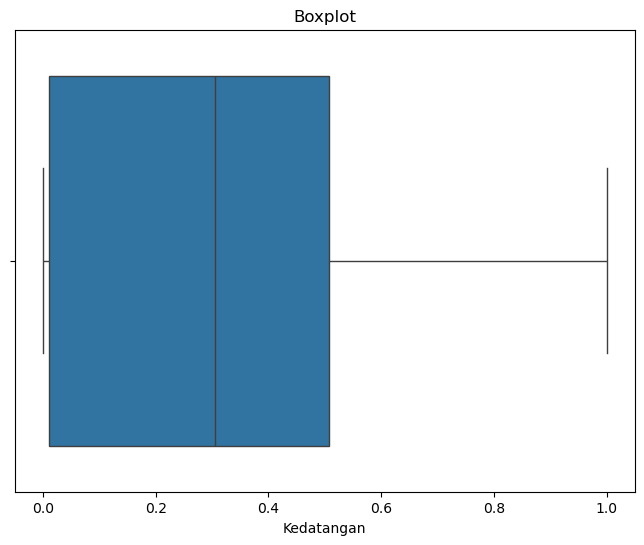

In [931]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=new_df['Kedatangan_Internasional'])
plt.title('Boxplot')
plt.xlabel('Kedatangan')
plt.show()

In [932]:
curr = pd.to_datetime(data.iloc[-1]['Tanggal']).strftime('%m/%d/%Y').split('/')
index = []
for i in range(12):
    m = int(curr[0])
    y = int(curr[2])
    if m < 12:
        curr[0] = str(m+1)
    else:
        curr[2] = str(y+1)
        curr[0] = str(1)
    idx = "/".join(curr)
    index.append(idx)
index_forecast = to_datetime(pd.Series(index))
index_forecast

0    2024-11-01
1    2024-12-01
2    2025-01-01
3    2025-02-01
4    2025-03-01
5    2025-04-01
6    2025-05-01
7    2025-06-01
8    2025-07-01
9    2025-08-01
10   2025-09-01
11   2025-10-01
dtype: datetime64[ns]

In [933]:
data['Tanggal'] = to_datetime(data['Tanggal'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Tahun                     94 non-null     int64         
 1   Bulan                     94 non-null     int64         
 2   Kedatangan_Internasional  94 non-null     int64         
 3   Periode                   94 non-null     int64         
 4   Tanggal                   94 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 3.8 KB


## Exploratory Data Analysis (EDA)

### Visualization

In [934]:
import matplotlib.pyplot as plt

def compare_pred_actual(results, title):
 
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.tight_layout(pad=5.0)

    # Plot predictions and actuals for each scenario
    for scenario, result in results.items():
        ax.plot(result['Tanggal'], result['Predictions'], label=f'{scenario} Predictions', linestyle='--')
        ax.plot(result['Tanggal'], result['Actuals'], label=f'{scenario} Actuals', alpha=0.7)

    plt.xlim([min(result['Tanggal']), max(result['Tanggal'])])

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator((4,8,12)))
    ax.xaxis.set_major_formatter(DateFormatter("\n%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.legend(loc='best')

    # Improve the x-axis formatting for dates
    ax.tick_params(axis='x', rotation=45)
    plt.show()


In [935]:
def visualize(data, var=[], label=''):
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title('Visualisasi Data', fontsize=20)

    for v in var:
        ax.plot(data['Tanggal'].iloc[0:], data[v].iloc[0:], label=v)
        
    plt.xlim([min(data['Tanggal']), max(data['Tanggal'])])
    plt.xlabel('Date', fontsize=15)

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator((4,8,12)))
    ax.xaxis.set_major_formatter(DateFormatter("\n%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    ax.get_yaxis().get_major_formatter().set_scientific(False)


    plt.legend()
    plt.show()

In [936]:
data

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,9394,1,2017-01-01
1,2017,2,8775,2,2017-02-01
2,2017,3,11305,3,2017-03-01
3,2017,4,13204,4,2017-04-01
4,2017,5,11792,5,2017-05-01
...,...,...,...,...,...
89,2024,6,6893,78,2024-06-01
90,2024,7,8652,79,2024-07-01
91,2024,8,8122,80,2024-08-01
92,2024,9,7461,81,2024-09-01


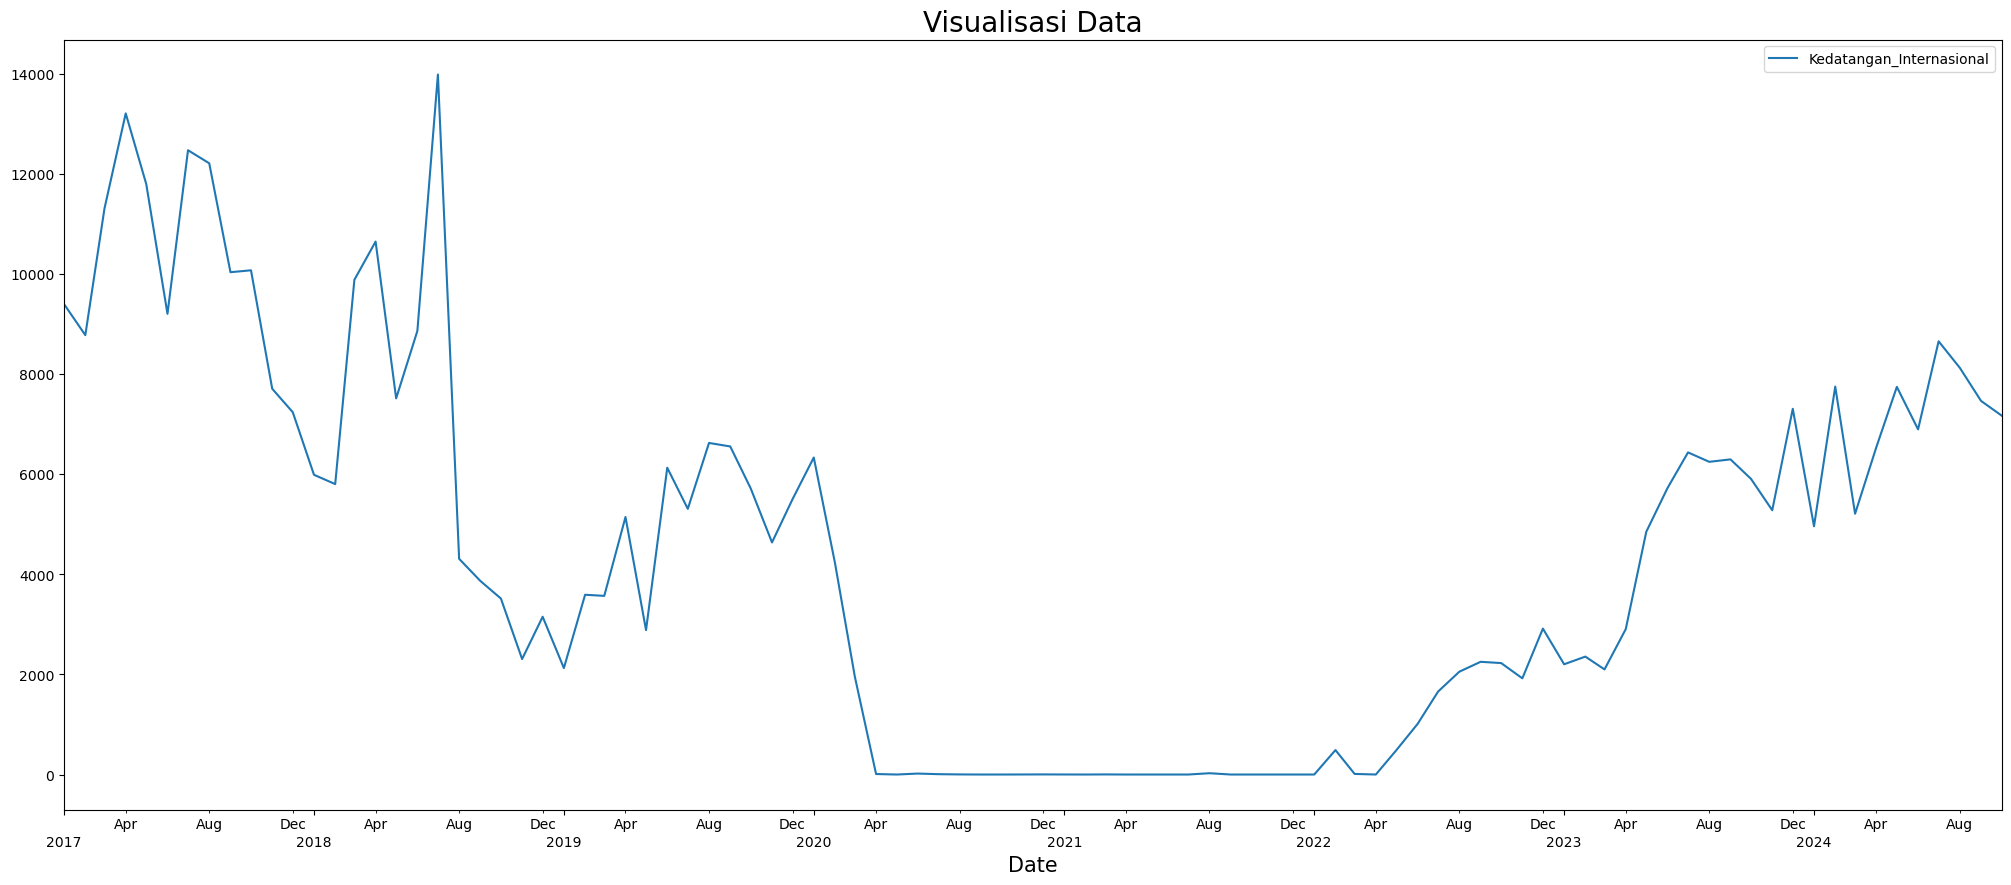

In [937]:
visualize(data, [ARRIVAL])

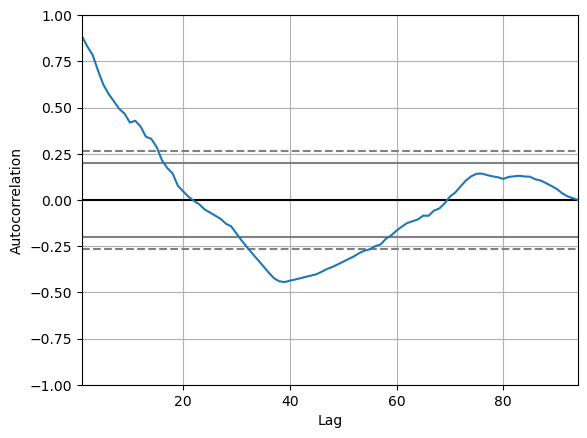

In [938]:


# Plot autocorrelation and partial autocorrelation
autocorrelation_plot(data[ARRIVAL])
plt.show()

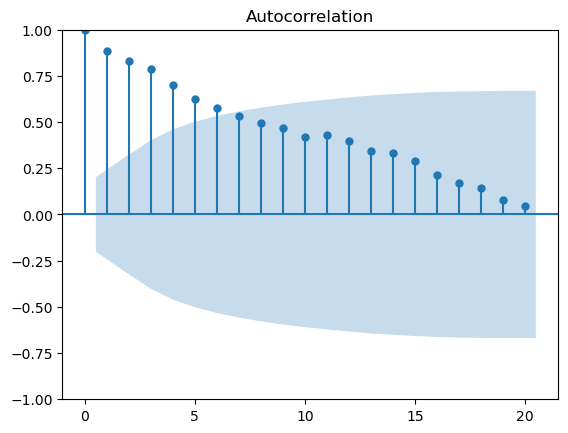

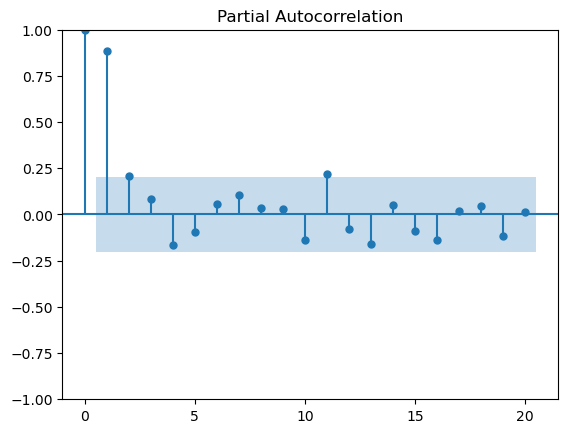

In [939]:
# Plot ACF dan PACF
plot_acf(data[ARRIVAL])
plot_pacf(data[ARRIVAL])
plt.show()

In [940]:
# Augmented Dickey-Fuller Test
def adf_test(data):
    result = adfuller(data, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(data[ARRIVAL])

ADF Statistic: -1.8235632254380563
p-value: 0.3688275378364241
Critical Values:
	1%: -3.503514579651927
	5%: -2.893507960466837
	10%: -2.583823615311909


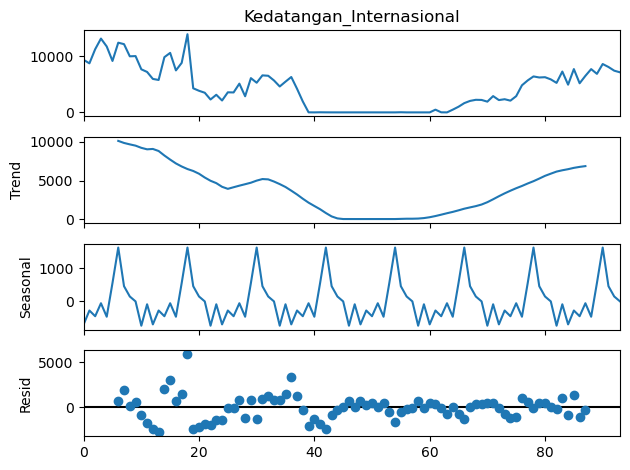

In [941]:
# Decompose time series data using the additive model
decomposition = seasonal_decompose(data[ARRIVAL], model='additive', period=12)  # Assuming a seasonal period of 12 (monthly)
decomposition.plot()
plt.show()

## Modeling
### Data Windows

In [942]:
def dataframe_to_windowed_data(df, window_size):
  df_as_np = df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    x.append(row)
    label = df_as_np[i+window_size]

    y.append(label)
  return np.array(x), np.array(y)

### Building Models
#### Prophet


#### SARIMA

In [943]:
data

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,9394,1,2017-01-01
1,2017,2,8775,2,2017-02-01
2,2017,3,11305,3,2017-03-01
3,2017,4,13204,4,2017-04-01
4,2017,5,11792,5,2017-05-01
...,...,...,...,...,...
89,2024,6,6893,78,2024-06-01
90,2024,7,8652,79,2024-07-01
91,2024,8,8122,80,2024-08-01
92,2024,9,7461,81,2024-09-01


In [944]:
def train_ARIMA(train_ratio=0.8, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12)):
	"""
	Create and train a SARIMA model and return predictions for both train and test sets.
	"""
	# Step 1: Split data into train and test sets
	train_size = int(len(data) * train_ratio)
	train, test = data.iloc[:train_size], data.iloc[train_size:]

	# Step 2: Fit the SARIMA model
	sarima_model = SARIMAX(
		train[ARRIVAL],
		order=order,
		seasonal_order=seasonal_order
	)
	sarima_fit = sarima_model.fit(disp=False)

	# Step 3: Generate SARIMA predictions for train and test sets
	train_predictions = sarima_fit.predict(start=train.index[0], end=train.index[-1])
	SARIMA_forecast = sarima_fit.get_forecast(steps=len(test))
	test_predictions = SARIMA_forecast.predicted_mean

	# Combine results
	train_results = pd.DataFrame({'Tanggal': train['Tanggal'], 'Actuals': train[ARRIVAL], 'Predictions': train_predictions})
	test_results = pd.DataFrame({'Tanggal': test['Tanggal'], 'Actuals': test[ARRIVAL], 'Predictions': test_predictions})

	return train_results, test_results

def forecast_ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 1, 12)):
	"""
	Create and train a SARIMA model and return predictions for both train and test sets.
	"""
	# Step 1: Fit the SARIMA model
	sarima_model = SARIMAX(
		data[ARRIVAL],
		order=order,
		seasonal_order=seasonal_order
	)
	sarima_fit = sarima_model.fit(disp=False)

	# Step 2: Generate SARIMA predictions for train and test sets
	SARIMA_forecast = sarima_fit.get_forecast(steps=FORECAST_WINDOW)
	forecast_predictions = SARIMA_forecast.predicted_mean

	# Combine results
	forecast_results = pd.DataFrame({'Predictions': forecast_predictions})

	return forecast_results
	


#### LSTM

In [945]:
def create_LSTM() -> Sequential:
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, 1), return_sequences=True))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(64, activation='relu'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(8, activation='relu'))
    model_LSTM.add(Dense(1, activation='linear'))
    model_LSTM.compile(optimizer='adam', loss='mse')
    return model_LSTM

def train_LSTM(train_ratio=0.8) -> dict:
    train_res = {}
    test_res = {}

    x, y = dataframe_to_windowed_data(data[ARRIVAL], WINDOW_SIZE)
    range_index_train = int(train_ratio * len(x))

    x_train, y_train = x[:range_index_train], y[:range_index_train]
    x_test, y_test = x[range_index_train:], y[range_index_train:]

    model_LSTM = create_LSTM()
    model_LSTM.fit(x_train, y_train, epochs=100, batch_size=2)

    train_predictions = model_LSTM.predict(x_train).flatten()
    train_results = pd.DataFrame(data={'Tanggal': data['Tanggal'][WINDOW_SIZE:range_index_train+WINDOW_SIZE], 'Predictions': train_predictions, 'Actuals': y_train})
    train_res[ARRIVAL] = train_results

    predictions_LSTM = model_LSTM.predict(x_test).flatten()
    test_results = pd.DataFrame(data={'Tanggal': data['Tanggal'][range_index_train+WINDOW_SIZE:], 'Predictions': predictions_LSTM, 'Actuals': y_test})
    test_res[ARRIVAL] = test_results

    return train_res, test_res

def forecast_LSTM(forecast_window):
    results = {}

    model = create_LSTM()
    x, y = dataframe_to_windowed_data(data[ARRIVAL], WINDOW_SIZE)
    model.fit(x, y, epochs=100, batch_size=2)
    
    forecast = []
    current_input = y[-WINDOW_SIZE:].reshape((1, WINDOW_SIZE, 1))
    
    for _ in range(forecast_window):
        next_pred = model.predict(current_input)[0, 0]
        forecast.append(next_pred)
        current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)
    
    forecast = pd.Series(forecast, index=index_forecast)
    results[ARRIVAL] = forecast
    
    return results


#### HYBRID (SARIMA-LSTM)

In [946]:
# 
def create_SARIMA_LSTM(data, arrival_column, train_ratio=0.8, window_size=12, epochs=100, batch_size=2):
    """
    Create Hybrid SARIMA-LSTM model:
    1. Train SARIMA to capture linear trends.
    2. Train LSTM to capture residual non-linear trends.
    """
    # Split data into train and test
    train_size = int(len(data) * train_ratio)
    train, test = data.iloc[:train_size], data.iloc[train_size:]

    # Step 1: Train SARIMA
    sarima_model = SARIMAX(
        train[arrival_column],
        order=(2, 1, 1),               # ARIMA parameters
        seasonal_order=(1, 1, 1, 12),  # Seasonal parameters
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_fit = sarima_model.fit(disp=False)

    # SARIMA Predictions
    sarima_train_predictions = sarima_fit.predict(start=train.index[0], end=train.index[-1])
    sarima_forecast = sarima_fit.get_forecast(steps=len(test))
    sarima_test_predictions = sarima_forecast.predicted_mean

    # Residuals for LSTM
    train_residuals = train[arrival_column] - sarima_train_predictions

    # Step 2: Train LSTM on Residuals
    def create_windowed_data(series, window_size):
        x, y = [], []
        for i in range(len(series) - window_size):
            x.append(series[i:i + window_size])
            y.append(series[i + window_size])
        return np.array(x), np.array(y)

    # Scale residuals
    residuals_scaled = (train_residuals - train_residuals.min()) / (train_residuals.max() - train_residuals.min())
    x, y = create_windowed_data(residuals_scaled.values, window_size)

    # Train-test split for LSTM
    split_idx = len(x) - len(test)  # Align LSTM residuals with test size
    x_train, y_train = x[:split_idx], y[:split_idx]
    x_test, y_test = x[split_idx:], y[split_idx:]

    # Create and Train LSTM
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, activation='relu', input_shape=(window_size, 1), return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(64, activation='relu'))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(8, activation='relu'))
    lstm_model.add(Dense(1, activation='linear'))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # LSTM Predictions (on residuals)
    lstm_train_predictions = lstm_model.predict(x_train).flatten()
    lstm_test_predictions = lstm_model.predict(x_test).flatten()

    # Reverse scaling
    lstm_train_predictions = lstm_train_predictions * (train_residuals.max() - train_residuals.min()) + train_residuals.min()
    lstm_test_predictions = lstm_test_predictions * (train_residuals.max() - train_residuals.min()) + train_residuals.min()

    # Step 3: Combine SARIMA and LSTM Predictions
    aligned_train = train.iloc[window_size:]  # Align train data with LSTM window
    sarima_train_predictions_aligned = sarima_train_predictions[window_size:]  # Align SARIMA with LSTM

    hybrid_train_predictions = sarima_train_predictions_aligned[:len(lstm_train_predictions)].values + lstm_train_predictions
    hybrid_test_predictions = sarima_test_predictions.values[:len(lstm_test_predictions)] + lstm_test_predictions

    # Align `aligned_train` with `hybrid_train_predictions`
    aligned_train = aligned_train.iloc[-len(hybrid_train_predictions):]

    # Combine Actuals
    train_results = pd.DataFrame({
        'Tanggal': aligned_train['Tanggal'],
        'Actuals': aligned_train[arrival_column],
        'Predictions': hybrid_train_predictions
    })
    test_results = pd.DataFrame({
        'Tanggal': test['Tanggal'][:len(hybrid_test_predictions)],
        'Actuals': test[arrival_column][:len(hybrid_test_predictions)],
        'Predictions': hybrid_test_predictions 
    })



    return train_results, test_results

def forecast_SARIMA_LSTM(data, arrival_column, forecast_window, window_size=12, epochs=100, batch_size=2):
    """
    Forecast using Hybrid SARIMA-LSTM model.
    """
    # Step 1: Train SARIMA
    sarima_model = SARIMAX(
        data[arrival_column],
        order=(2, 1, 1),               # ARIMA parameters
        seasonal_order=(1, 1, 1, 12),  # Seasonal parameters
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_fit = sarima_model.fit(disp=False)

    # SARIMA Predictions
    sarima_forecast = sarima_fit.get_forecast(steps=forecast_window)
    sarima_predictions = sarima_forecast.predicted_mean

    # Step 2: Train LSTM on Residuals
    residuals = data[arrival_column] - sarima_fit.fittedvalues

    # Scale residuals
    residuals_scaled = (residuals - residuals.min()) / (residuals.max() - residuals.min())

    # Create windowed data
    x, y = dataframe_to_windowed_data(residuals_scaled, window_size)

    # Train LSTM
    lstm_model = create_LSTM()
    lstm_model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Forecast LSTM
    forecast = []
    current_input = residuals_scaled[-window_size:].values.reshape((1, window_size, 1))

    for _ in range(forecast_window):
        next_pred = lstm_model.predict(current_input)[0, 0]
        forecast.append(next_pred)

        # Update input
        current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)

    # Reverse scaling
    forecast = np.array(forecast) * (residuals.max() - residuals.min()) + residuals.min()

    # Combine SARIMA and LSTM forecasts
    forecast_results = pd.DataFrame({
        'Tanggal': index_forecast,
        'Predictions': sarima_predictions + forecast
    })

    return forecast_results

## Training and Testing

1. 80% Train - 20% Test
2. 70% Train - 30 % Test
3. 60% Train - 40 % Test


## Evaluation


### Prophet

### SARIMA

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


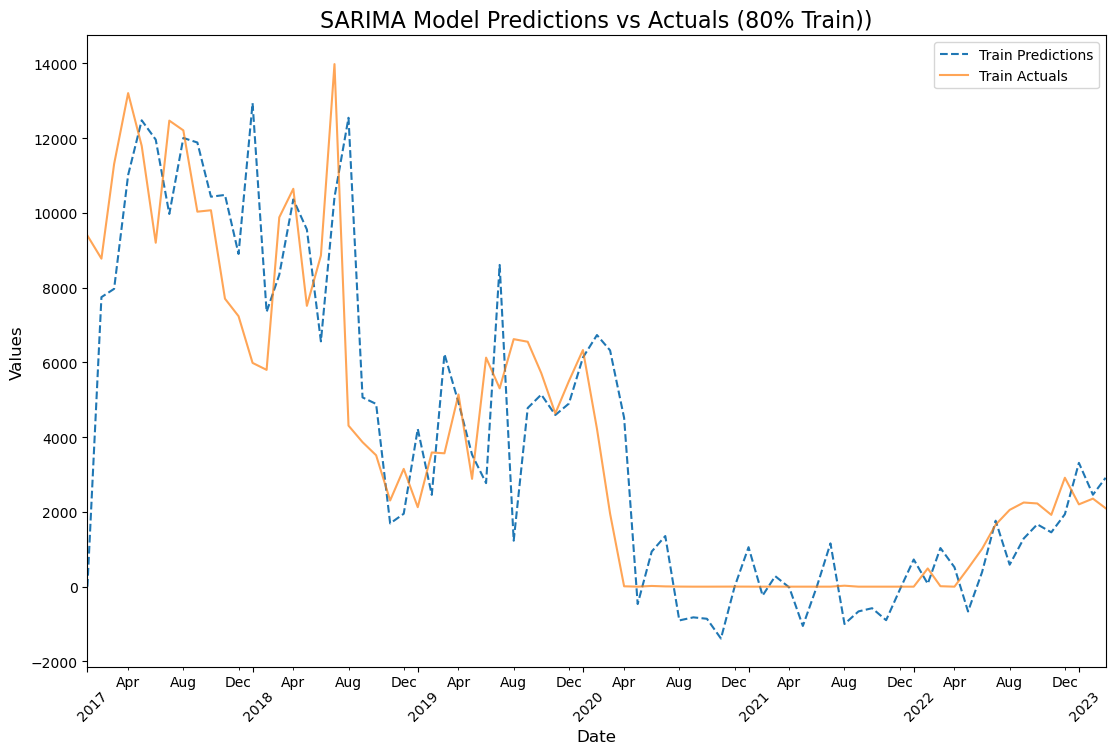

ARIMA Model Evaluation Metrics (80% Train):
MSE: 5591991.899135302
MAE: 1569.915643683268
MAPE: inf
R²: 0.658489209809147


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


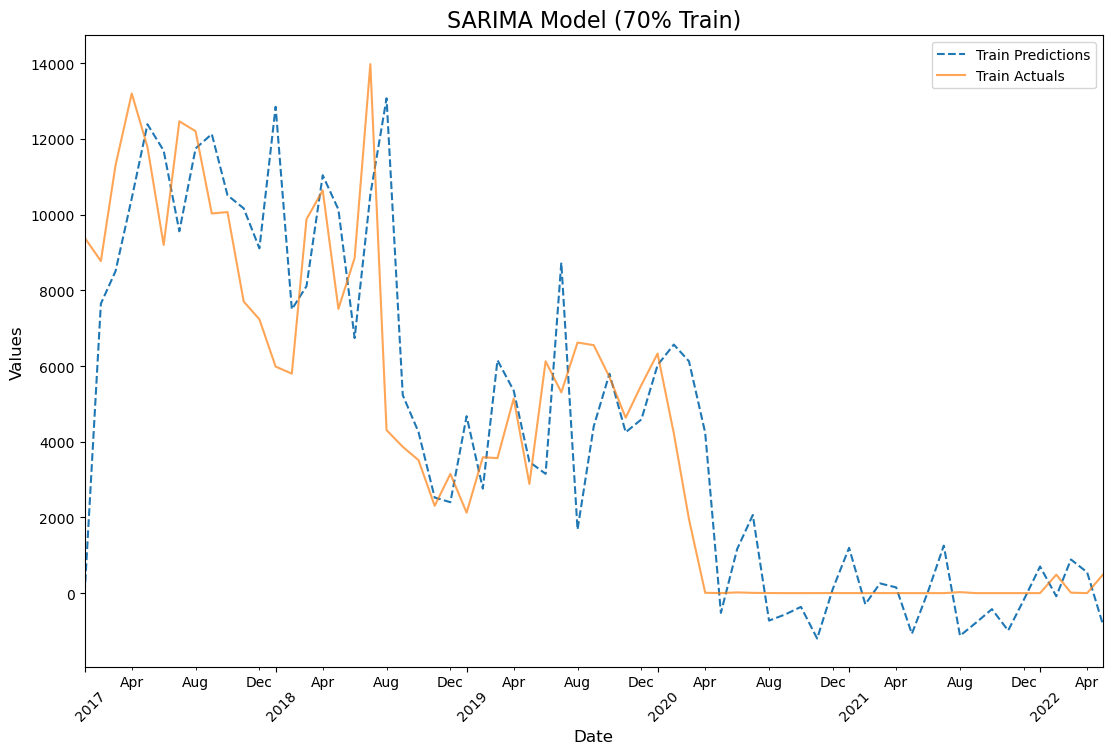

ARIMA Model Evaluation Metrics (70% Train):
MSE: 6400175.335204091
MAE: 1713.3276138890508
MAPE: inf
R²: 0.6491322227814318


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


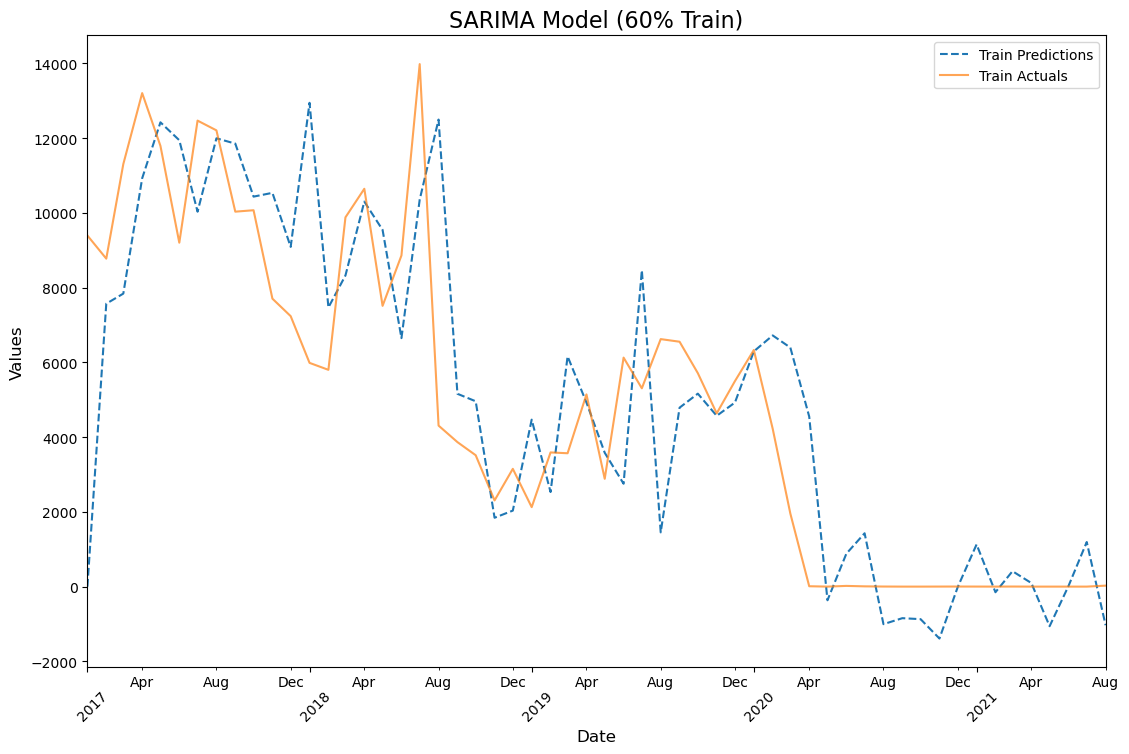

ARIMA Model Evaluation Metrics (60% Train):
MSE: 7296312.265315372
MAE: 1876.8146562784584
MAPE: inf
R²: 0.594854412917434


In [947]:
# Scenario 1: 80% Train - 20% Test
SARIMA_train_results_80, _ = train_ARIMA(0.8)
compare_pred_actual({'Train': SARIMA_train_results_80}, 'SARIMA Model Predictions vs Actuals (80% Train))')

# Evaluate the ARIMA model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(SARIMA_train_results_80['Actuals'], SARIMA_train_results_80['Predictions'])
print(f"ARIMA Model Evaluation Metrics (80% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 2: 70% Train - 30% Test
SARIMA_train_results_70, _ = train_ARIMA(0.7)
compare_pred_actual({'Train': SARIMA_train_results_70}, 'SARIMA Model (70% Train)')

# Evaluate the ARIMA model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(SARIMA_train_results_70['Actuals'], SARIMA_train_results_70['Predictions'])
print(f"ARIMA Model Evaluation Metrics (70% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 3: 60% Train - 40% Test
SARIMA_train_results_60, _ = train_ARIMA(0.6)
compare_pred_actual({'Train': SARIMA_train_results_60}, 'SARIMA Model (60% Train)')

# Evaluate the ARIMA model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(SARIMA_train_results_60['Actuals'], SARIMA_train_results_60['Predictions'])
print(f"ARIMA Model Evaluation Metrics (60% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

### LSTM

Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 10843011.0000
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9924926.0000 
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9444954.0000
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5869857.5000
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4354316.5000
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7249868.0000
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12686057.0000
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4863246.5000
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5944066.5000
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7892357.5000
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5933714.5000
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7284045.0000
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5781458.5000
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9231259.0

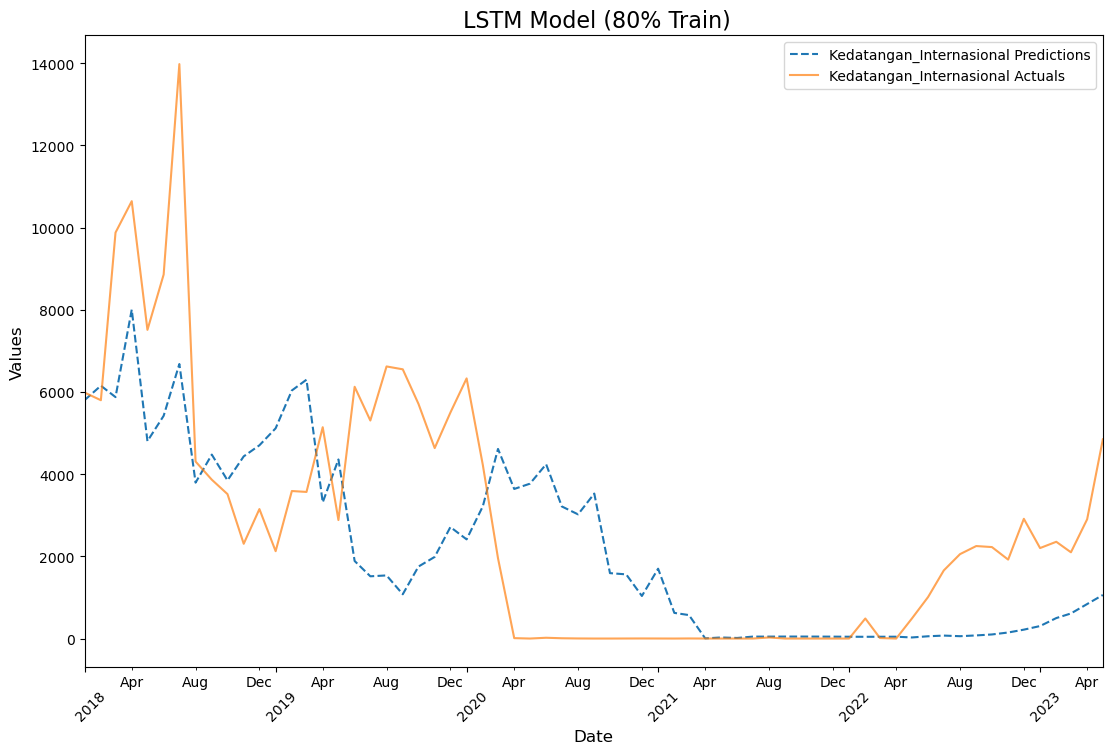

LSTM Model Evaluation Metrics:
MSE: 0.011992005534626237
MAE: 0.09131867520975843
MAPE: 39.76324452030369
R²: -1.3971020434085935
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17228230.0000
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7075888.5000 
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14689688.0000
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5592724.5000
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5253275.0000
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4705866.5000
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7879527.5000
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4488601.5000
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6665216.0000
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11731440.0000
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4769379.0000
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18324134.0000
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14827963.0000
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103767

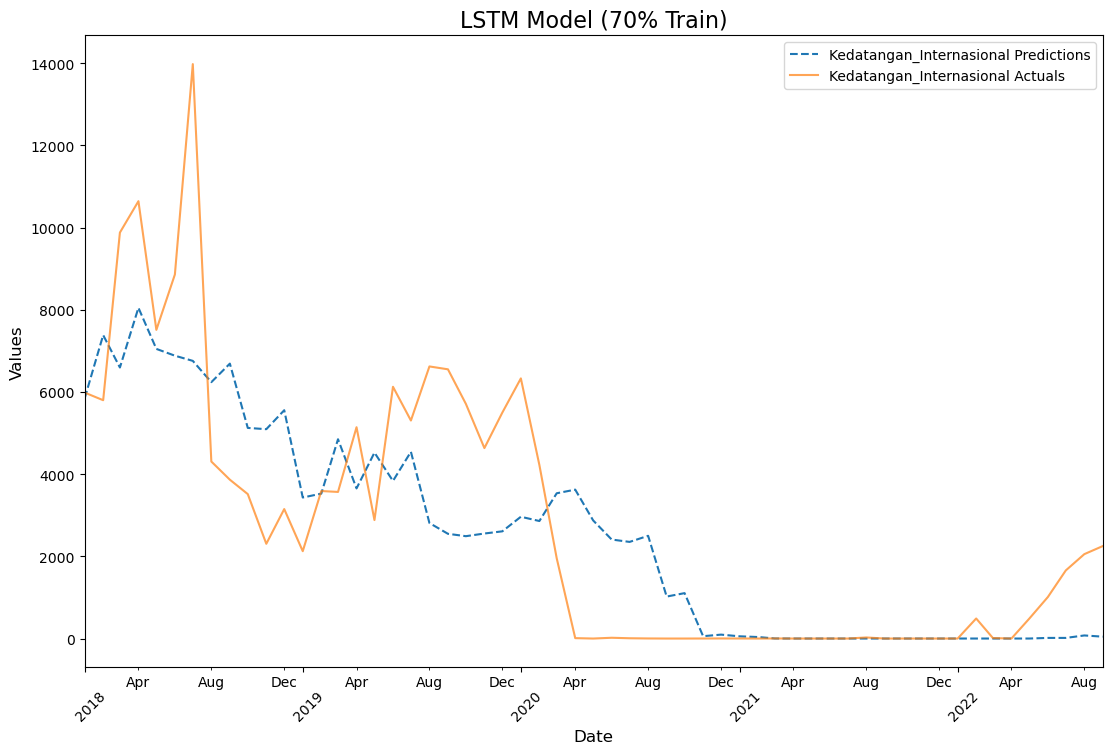

LSTM Model Evaluation Metrics:
MSE: 0.011992005534626237
MAE: 0.09131867520975843
MAPE: 39.76324452030369
R²: -1.3971020434085935
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21315850.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17926062.0000 
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13501499.0000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20699902.0000
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11165216.0000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8760428.0000
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9070065.0000
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10725688.0000
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8954145.0000
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7089931.5000
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10578809.0000
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15576310.0000
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14768380.0000
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25

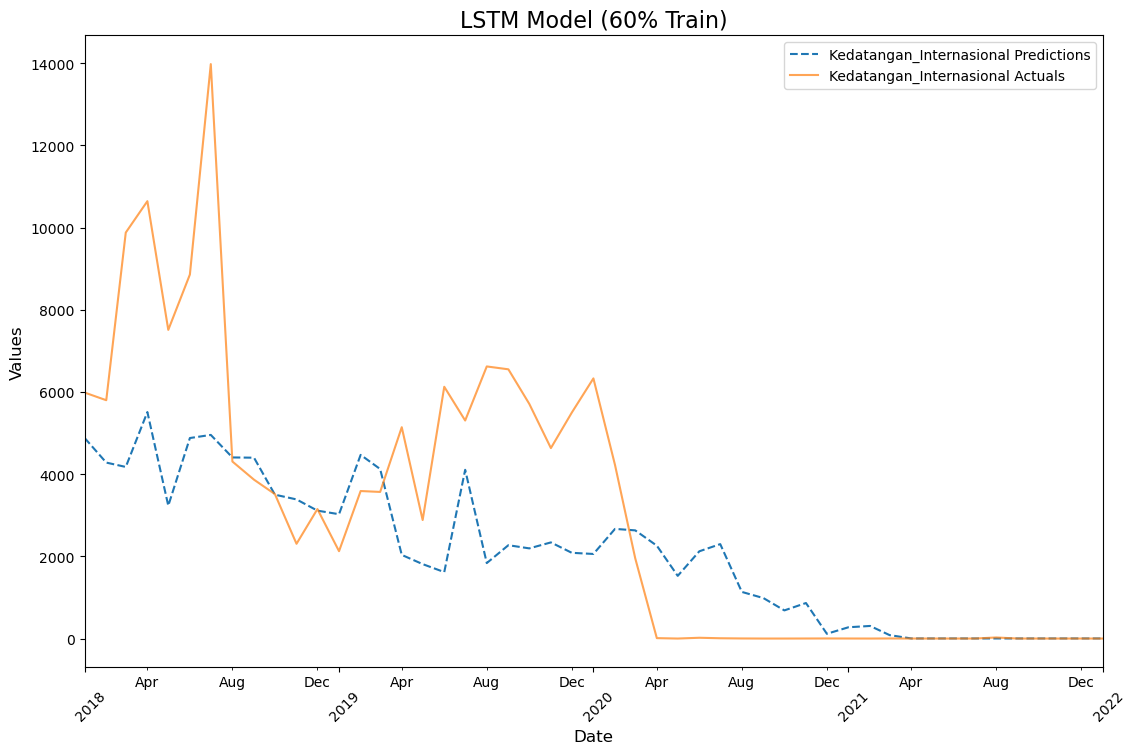

LSTM Model Evaluation Metrics:
MSE: 0.011992005534626237
MAE: 0.09131867520975843
MAPE: 39.76324452030369
R²: -1.3971020434085935


In [948]:
# Scenario 1: 80% Train - 20% Test
LSTM_train_results_80, LSTM_test_results_80 = train_LSTM(0.8)
compare_pred_actual(LSTM_train_results_80, title=" LSTM Model (80% Train)")

# Evaluate the LSTM model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(LSTM_test_results[ARRIVAL]['Actuals'], LSTM_test_results[ARRIVAL]['Predictions'])
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 1: 70% Train - 30% Test
LSTM_train_results_70, LSTM_test_results_70 = train_LSTM(0.7)
compare_pred_actual(LSTM_train_results_70, title="LSTM Model (70% Train)")

# Evaluate the LSTM model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(LSTM_test_results[ARRIVAL]['Actuals'], LSTM_test_results[ARRIVAL]['Predictions'])
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 1: 60% Train - 40% Test
LSTM_train_results_60, LSTM_test_results_60 = train_LSTM(0.6)
compare_pred_actual(LSTM_train_results_60, title="LSTM Model (60% Train)")

# Evaluate the LSTM model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(LSTM_test_results[ARRIVAL]['Actuals'], LSTM_test_results[ARRIVAL]['Predictions'])
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")



### HYBRID (SARIMA-LSTM)

Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1923
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326     
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0367
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 
Epoch 1

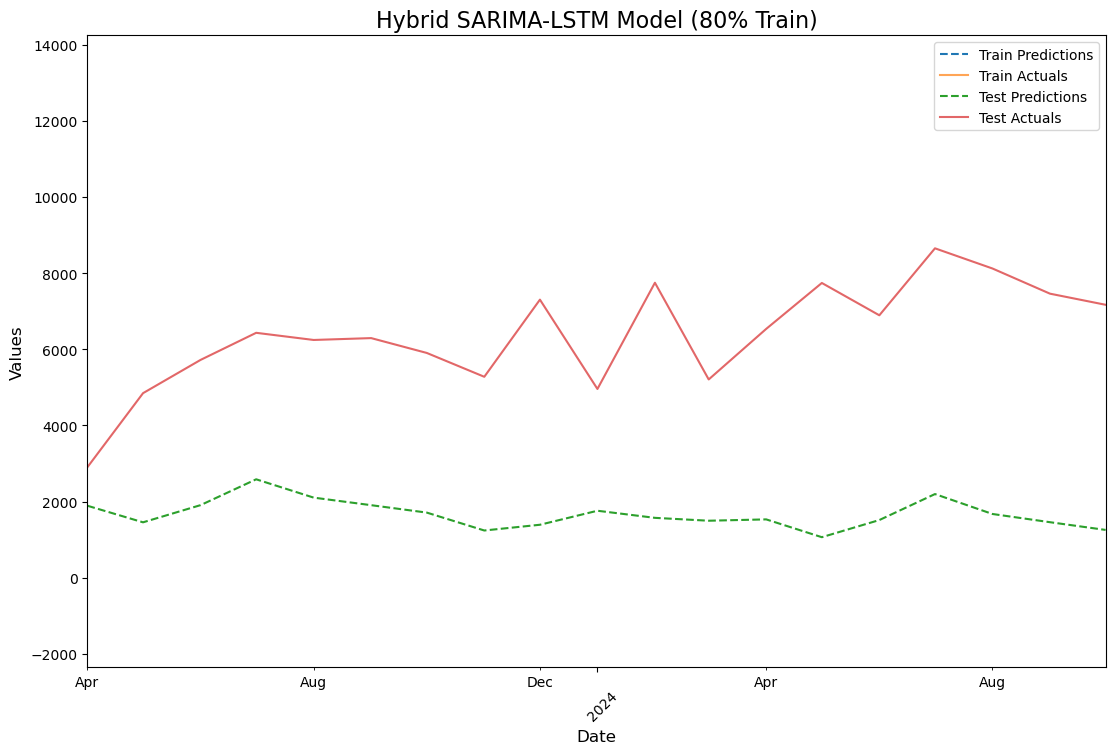

Hybrid Model Evaluation Metrics (80% Train):
MSE: 24313921.854295395
MAE: 4720.642047229362
MAPE: 72.04719325530012
R²: -12.3557418285502
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2090 
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0943 
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0254
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0375
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0795 
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0307
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0359
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0377 
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0329 
Epoch 16/1

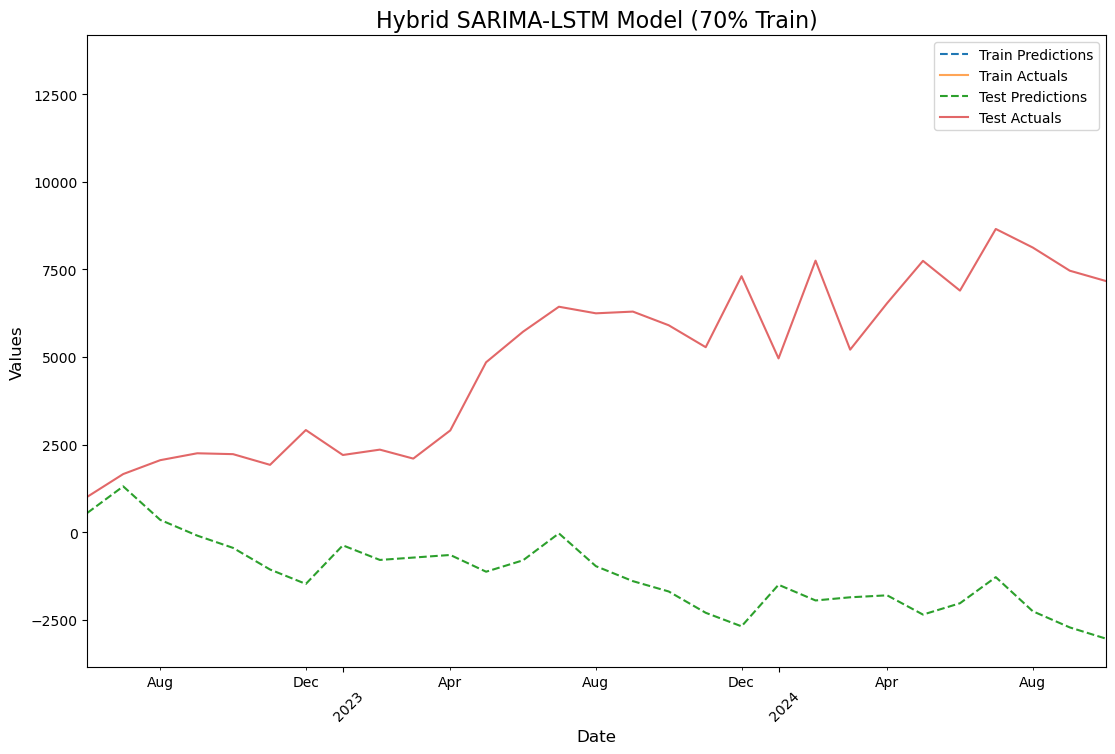

Hybrid Model Evaluation Metrics (70% Train):
MSE: 47537714.999015234
MAE: 6115.368504621826
MAPE: 119.7500745975171
R²: -7.6638363553333
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2862
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1732 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1968
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1658
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1551
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1303
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1205
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0557
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0401
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0335
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0360
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0579
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0432
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297
Epoch 16/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

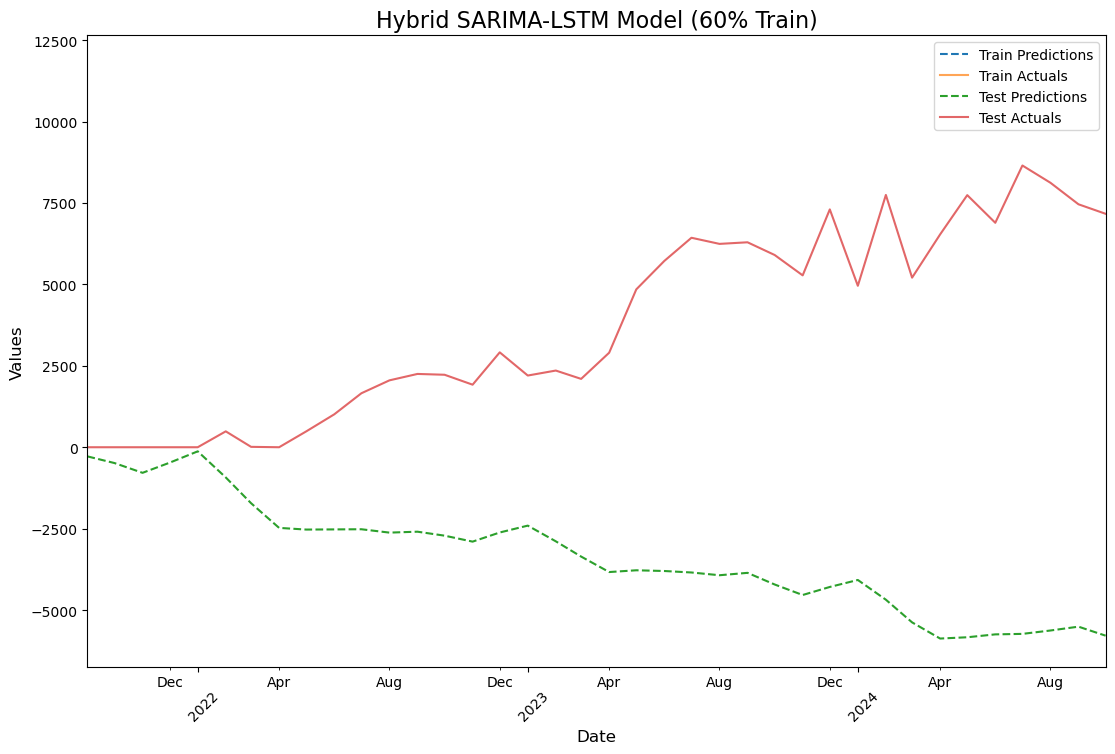

Hybrid Model Evaluation Metrics (60% Train):
MSE: 70729071.84374152
MAE: 7115.346016102419
MAPE: inf
R²: -7.475300590804757


In [949]:
# Scenario 1: 80% Train - 20% Test
HYBRID_train_results_80, HYBRID_test_results_80 = create_SARIMA_LSTM(
    data=data, arrival_column=ARRIVAL, train_ratio=0.8
)
compare_pred_actual({'Train': HYBRID_train_results_80, 'Test': HYBRID_test_results_80}, 'Hybrid SARIMA-LSTM Model (80% Train)')
# Evaluate the Hybrid model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(HYBRID_test_results_80['Actuals'], HYBRID_test_results_80['Predictions'])
print(f"Hybrid Model Evaluation Metrics (80% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 2: 70% Train - 30% Test
HYBRID_train_results_70, HYBRID_test_results_70 = create_SARIMA_LSTM(
    data=data, arrival_column=ARRIVAL, train_ratio=0.7
)
compare_pred_actual({'Train': HYBRID_train_results_70, 'Test': HYBRID_test_results_70}, 'Hybrid SARIMA-LSTM Model (70% Train)')
# Evaluate the Hybrid model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(HYBRID_test_results_70['Actuals'], HYBRID_test_results_70['Predictions'])
print(f"Hybrid Model Evaluation Metrics (70% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 1: 60% Train - 40% Test
HYBRID_train_results_60, HYBRID_test_results_60 = create_SARIMA_LSTM(
    data=data, arrival_column=ARRIVAL, train_ratio=0.6
)
compare_pred_actual({'Train': HYBRID_train_results_60, 'Test': HYBRID_test_results_60}, 'Hybrid SARIMA-LSTM Model (60% Train)')
# Evaluate the Hybrid model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(HYBRID_test_results_60['Actuals'], HYBRID_test_results_60['Predictions'])
print(f"Hybrid Model Evaluation Metrics (60% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

## Implementation


### Combine Historical and Forecast Data

In [950]:
def combine_data(region, forecast, data):
    historical = data[['Tanggal', region]].copy()
    historical.columns = ['Tanggal', 'Historical']
    forecast.columns = ['Tanggal', 'Forecast']
    combined = pd.merge(historical, forecast, on='Tanggal', how='outer')
    return combined

In [951]:
# Make Comparsion Visualization Historical,Forecast
def visualize_forecast(region, forecast, data):
    combined = combine_data(region, forecast, data)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(combined['Tanggal'], combined['Historical'], label='Historical', color='blue')
    ax.plot(combined['Tanggal'], combined['Forecast'], label='Forecast', color='red')
    ax.set_title(f'{region} Forecast vs Actual')
    ax.set_xlabel('Date')
    ax.set_ylabel(region)
    ax.legend(loc='upper left')
    plt.show()

### Prophet

### SARIMA

In [952]:
# Forecast ARIMA
SARIMA_forecast = forecast_ARIMA()
SARIMA_forecast

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Predictions
94,6480.823232
95,7364.565077
96,6977.005494
97,7862.462937
98,7311.519118
99,8025.003080
100,8076.707491
101,8064.800884
102,9402.700951
103,8545.563716


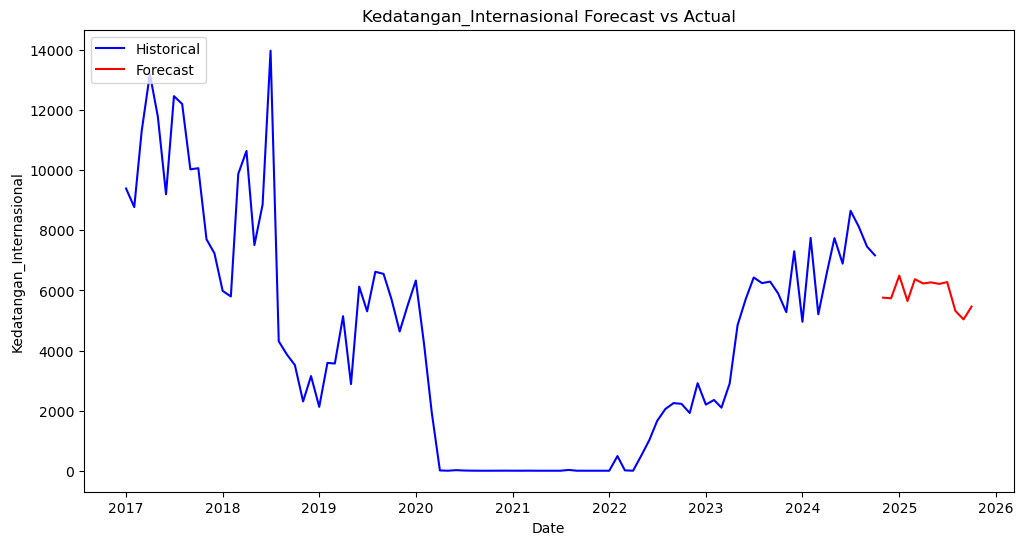

In [984]:
# Forecast SARIMA
forecast_SARIMA = forecast_ARIMA()

# Visualize the SARIMA forecast
forecast = forecast_SARIMA.reset_index()
forecast.columns = ['Tanggal', 'Forecast']
combined_data = combine_data(ARRIVAL, forecast, data)
visualize_forecast(ARRIVAL, forecast, data)
Visualize the LSTM forecast

#### LSTM

In [956]:
LSTM_forecast = forecast_LSTM(FORECAST_WINDOW)

Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14161155.0000
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7864512.0000
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9852832.0000 
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7510414.0000
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7984811.5000
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7178273.0000
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8785887.0000
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7856955.0000
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9338785.0000
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7470122.5000
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8184006.0000
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9982208.0000 
Epoch 13/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10282952.0000
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8612515.

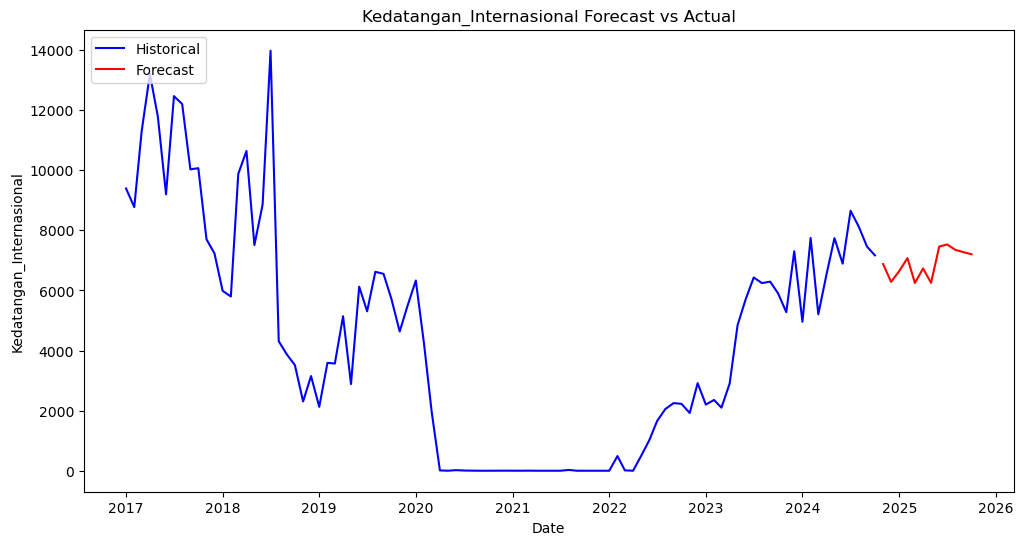

In [974]:
# Visualize the LSTM forecast
forecast = LSTM_forecast[ARRIVAL].reset_index()
forecast.columns = ['Tanggal', 'Forecast']
combined_data = combine_data(ARRIVAL, forecast, data)
visualize_forecast(ARRIVAL, forecast, data)

### Hybrid (SARIMA-LSTM)

In [824]:
# Generate Hybrid SARIMA-LSTM forecast
HYBRID_forecast = forecast_SARIMA_LSTM(data, ARRIVAL, FORECAST_WINDOW)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1753
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116   
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117
Epoch 13/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140
Epoch 15/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137
Epoch 16/100


In [825]:
HYBRID_forecast

,Tanggal,Predictions
0,2024-11-01,NaN
1,2024-12-01,NaN
2,2025-01-01,NaN
3,2025-02-01,NaN
4,2025-03-01,NaN
5,2025-04-01,NaN
6,2025-05-01,NaN
7,2025-06-01,NaN
8,2025-07-01,NaN
9,2025-08-01,NaN
